In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [2]:
len(train_targets)

404

In [3]:
# 데이터 정규화
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std
# mean(axis=0) : 각 컬럼의 mean 값을 구한다.
# mean(axis=1) : 각 로우의 mean 값을 구한다.

In [4]:
train_data.shape[1]

13

In [5]:
from keras import models, layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', 
                         input_shape=(train_data.shape[1], )))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  # 연속된 값을 예측하는 회귀(스칼라 회귀)는 마지막층에 
  # 하나의 유닛을 가지며 활성화 함수가 없다.
  # 마지막이 선형이라서 어떤 범위의 값이라도 예측하도록 자유롭게 학습
  model.compile(
      optimizer='rmsprop',
      loss='mse',
      metrics=['mae']
  )
  return model

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('처리중인 fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_target = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], 
      train_data[(i+1)*num_val_samples:]],       
      axis=0,
  )
  partial_train_target = np.concatenate(
      [train_targets[:i*num_val_samples], 
      train_targets[(i+1)*num_val_samples:]],       
      axis=0
  )

  model = build_model()
  model.fit(partial_train_data, partial_train_target,
            epochs=num_epochs, batch_size=1, verbose=0)
  
  val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)
  all_scores.append(val_mae)

처리중인 fold # 0
처리중인 fold # 1
처리중인 fold # 2
처리중인 fold # 3


In [7]:
print(all_scores)
print(np.mean(all_scores))

[1.9885250329971313, 2.485821008682251, 2.7648675441741943, 2.6004638671875]

In [11]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('처리중인 fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_target = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], 
      train_data[(i+1)*num_val_samples:]],       
      axis=0,
  )
  partial_train_target = np.concatenate(
      [train_targets[:i*num_val_samples], 
      train_targets[(i+1)*num_val_samples:]],       
      axis=0
  )

  model = build_model()
  history = model.fit(partial_train_data, partial_train_target,
                      validation_data=(val_data, val_target),
                      epochs=num_epochs, batch_size=1, verbose=0)
  
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

처리중인 fold # 0
처리중인 fold # 1
처리중인 fold # 2
처리중인 fold # 3


In [17]:
history.history.keys()
print(np.shape(all_mae_histories))

(4, 500)


[4.544438123703003, 3.3848909735679626, 3.0565178990364075, 2.783764600753784, 2.6935007572174072, 2.718448042869568, 2.7027612924575806, 2.565141797065735, 2.707654118537903, 2.582340657711029, 2.539408266544342, 2.662700831890106, 2.5591084957122803, 2.547402322292328, 2.493259847164154, 2.5093517899513245, 2.5360770225524902, 2.550146460533142, 2.3832852244377136, 2.4380502700805664, 2.433073043823242, 2.450594961643219, 2.60245418548584, 2.381628304719925, 2.4330999851226807, 2.41581991314888, 2.3400973677635193, 2.431135356426239, 2.6137858629226685, 2.415520668029785, 2.396928995847702, 2.416849583387375, 2.404678612947464, 2.420965075492859, 2.3766950368881226, 2.382298767566681, 2.4244135916233063, 2.328578859567642, 2.5038737058639526, 2.410973846912384, 2.3183173537254333, 2.3542503118515015, 2.4051597118377686, 2.3777127265930176, 2.571716010570526, 2.364266812801361, 2.24859482049942, 2.5066903233528137, 2.4522826075553894, 2.3538647294044495, 2.3186533451080322, 2.46070069

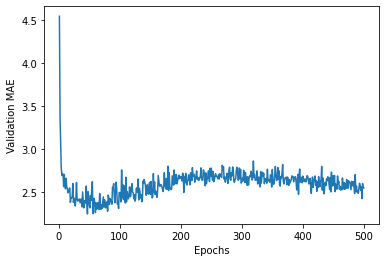

In [19]:
average_mae_history = [
  np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
# print(average_mae_history)

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

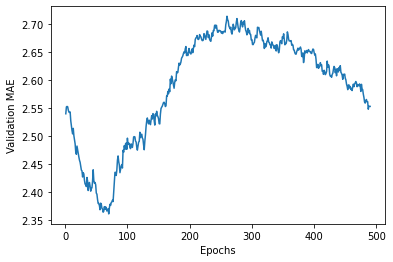

In [22]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, 1+len(smooth_mae_history)), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

MAE가 80이후로 줄어드는 것이 멈추었다. 이때부터 과적합이 시작된다.


In [24]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 21.1131 - mae: 2.9077
